In [44]:
import os
import torch
import optuna
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from datetime import datetime
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score

import warnings
warnings.filterwarnings("ignore")

<div style="background: linear-gradient(to right, #FFD6A5, #FDFFB6); padding:20px; border-radius:10px; margin-top:20px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h2 style="color:#2B2D42; text-align:center;">📦 Data Collection & Data Reading</h2>
</div> 

In [45]:
participant_data = pd.read_csv("participants.tsv", sep='\t')
wearable_activity_monitor_data = pd.read_csv("wearable_activity_monitor/manifest.tsv", sep='\t')
wearable_blood_glucose_data = pd.read_csv("wearable_blood_glucose/manifest.tsv", sep='\t')
cardiac_ecg_data = pd.read_csv("cardiac_ecg/manifest.tsv", sep='\t')
environment_manifest_data = pd.read_csv('environment/manifest.tsv', sep='\t')

person_data = pd.read_csv('clinical_data/person.csv', on_bad_lines='skip')
visit_occurrence_data = pd.read_csv('clinical_data/visit_occurrence.csv', on_bad_lines='skip')
condition_occurrence_data = pd.read_csv('clinical_data/condition_occurrence.csv', on_bad_lines='skip')
participant_conditions_data = pd.read_csv('condition_dataset.csv', on_bad_lines='skip')
measurement_data = pd.read_csv('clinical_data/measurement.csv', on_bad_lines='skip')

In [46]:
person_data = person_data[["person_id","year_of_birth"]]

visit_occurrence_data = visit_occurrence_data[["visit_occurrence_id","person_id", "visit_start_date", "visit_end_date"]]

condition_occurrence_data = condition_occurrence_data[["condition_occurrence_id","person_id", "condition_start_date", "condition_end_date"
                                                       ,"visit_occurrence_id", "condition_source_value"]]

measurement_data = measurement_data[["measurement_id","person_id", "measurement_concept_id", "measurement_date", "measurement_type_concept_id",
                                               "value_as_number", "visit_occurrence_id", "measurement_source_value"
                                                       ,"unit_source_value", "value_source_value"]]

In [47]:
#participant_conditions_data = participant_conditions_data[participant_conditions_data["category"] == "Metabolic"]
#participant_conditions_data

In [48]:
visit_occurrence_data['visit_start_date'] = pd.to_datetime(visit_occurrence_data['visit_start_date'])
visit_occurrence_data['visit_end_date'] = pd.to_datetime(visit_occurrence_data['visit_end_date'])

visit_occurrence_grouped_data = visit_occurrence_data.groupby('person_id').agg(
    first_visit_start_date=('visit_start_date', 'min'),
    last_visit_end_date=('visit_end_date', 'max')
).reset_index()

condition_occurrence_data['condition_start_date'] = pd.to_datetime(condition_occurrence_data['condition_start_date'])
condition_occurrence_data['condition_end_date'] = pd.to_datetime(condition_occurrence_data['condition_end_date'])

condition_occurrence_grouped_data = condition_occurrence_data.groupby('person_id').agg(
    first_condition_start_date=('condition_start_date', 'min'),
    last_condition_end_date=('condition_end_date', 'max'),
    all_conditions=('condition_source_value', lambda x: ' # '.join(x))
).reset_index()

clinical_data = person_data.merge(visit_occurrence_grouped_data, on='person_id', how='left').merge(condition_occurrence_grouped_data, on='person_id', how='left')
clinical_data.rename(columns={'person_id': 'participant_id'}, inplace=True)

clinical_data_column_names = ['participant_id'] + ['clinical_' + col for col in clinical_data.columns[1:]]
clinical_data.columns = clinical_data_column_names

measurement_data.rename(columns={'person_id': 'participant_id'}, inplace=True)
condition_occurrence_data.rename(columns={'person_id': 'participant_id'}, inplace=True)
condition_grouped_data = condition_occurrence_data.groupby(['participant_id', 'visit_occurrence_id']).agg(
    first_condition_start_date=('condition_start_date', 'min'),
    last_condition_end_date=('condition_end_date', 'max'),
    all_conditions=('condition_source_value', lambda x: ' # '.join(x))
).reset_index()
combined_measurement_data = measurement_data.merge(condition_grouped_data, on=["participant_id", "visit_occurrence_id"], how="left")

In [49]:
participant_filtered_data = participant_data[["participant_id","clinical_site", "study_group", "age", "study_visit_date", "recommended_split", 
                                             "cardiac_ecg", "clinical_data", "environment", "wearable_activity_monitor", "wearable_blood_glucose"]]

wearable_activity_monitor_filtered_data = wearable_activity_monitor_data[["participant_id", "wrist_worn_on", "dominant_hand", "heartrate_record_count",
                                                                         "average_heartrate_bpm", "oxygen_saturation_record_count", "average_oxygen_saturation_pct",
                                                                         "average_respiratory_rate_bpm", "physical_activity_num_days", "average_daily_activity",
                                                                         "active_calories_record_count", "average_active_calories_kcal", "sensor_sampling_duration_days"
                                                                         ]]

wearable_blood_glucose_filtered_data = wearable_blood_glucose_data[["participant_id", "glucose_level_record_count", "average_glucose_level_mg_dl",
                                                                   "glucose_sensor_sampling_duration_days"]]

cardiac_ecg_filtered_data = cardiac_ecg_data[["participant_id", "PR", "QRSD", "QT", "QTc", "P", "QRS", "T"]]
ecg_column_names = ['participant_id'] + ['cardiac_ecg_' + col for col in cardiac_ecg_filtered_data.columns[1:]]
cardiac_ecg_filtered_data.columns = ecg_column_names

environment_manifest_filtered_data = environment_manifest_data[["participant_id", "sensor_location", "number_of_observations", "sensor_sampling_extent_in_days"]]
environment_column_names = ['participant_id'] + ['environmental_' + col for col in environment_manifest_filtered_data.columns[1:]]
environment_manifest_filtered_data.columns = environment_column_names

In [50]:
for index, row in environment_manifest_data.iterrows():
    file_path = row['env_sensor_filepath']
    cleaned_file_path = file_path.replace("/environment/", "environment/")
    
    environmental_data = pd.read_csv(cleaned_file_path, skiprows=45, on_bad_lines='skip')
    environmental_average_data = environmental_data.drop(columns=['ts']).mean()
    environmental_average_row = environmental_average_data.to_frame().T
    environmental_average_row['participant_id'] = row['participant_id']

    if index == 0:
        final_environmental_data = environmental_average_row
    else:
        final_environmental_data = pd.concat([final_environmental_data, environmental_average_row], ignore_index=True)
        
simplified_column_mapping = {'lch0': 'wavelength_415nm', 'lch1': 'wavelength_445nm', 'lch2': 'wavelength_480nm', 'lch3': 'wavelength_515nm',
    'lch6': 'wavelength_555nm', 'lch7': 'wavelength_590nm', 'lch8': 'wavelength_630nm', 'lch9': 'wavelength_680nm', 'lch10': 'clear_no_filter',
    'lch11': 'wavelength_910nm', 'pm1': 'pm_1', 'pm2.5': 'pm_2_5', 'pm4': 'pm_4', 'pm10': 'pm_10', 'hum': 'relative_humidity', 'temp': 'ambient_temperature',
    'voc': 'voc', 'nox': 'nox', 'screen': 'screen_state', 'ff': 'flicker_detection', 'inttemp': 'internal_rtc_board_temperature', 'participant_id': 'participant_id'}

final_environmental_data.rename(columns=simplified_column_mapping, inplace=True)

In [51]:
environment_column_names = ['environmental_' + col for col in final_environmental_data.columns[:21]] + ['participant_id']
final_environmental_data.columns = environment_column_names

In [52]:
calculated_patient_data = participant_filtered_data.merge(wearable_activity_monitor_filtered_data, on="participant_id", how="left") \
    .merge(wearable_blood_glucose_filtered_data, on="participant_id", how="left").merge(cardiac_ecg_filtered_data, on="participant_id", how="left") \
    .merge(environment_manifest_filtered_data, on="participant_id", how="left").merge(final_environmental_data, on="participant_id", how="left") \
    .merge(clinical_data, on="participant_id", how="left")

In [53]:
test_record = participant_data[(participant_data["cardiac_ecg"] == True) & (participant_data["clinical_data"] == True)
                                & (participant_data["environment"] == True) & (participant_data["wearable_activity_monitor"] == True)
                                & (participant_data["wearable_blood_glucose"] == True)].iloc[0]
test_data = calculated_patient_data[calculated_patient_data["participant_id"] == int(test_record["participant_id"])]
test_data.iloc[0]

participant_id                                                                      1023
clinical_site                                                                         UW
study_group                                                            insulin_dependent
age                                                                                   67
study_visit_date                                                              2023-08-30
                                                             ...                        
clinical_first_visit_start_date                                      2023-08-30 00:00:00
clinical_last_visit_end_date                                         2023-08-30 00:00:00
clinical_first_condition_start_date                                  2023-07-18 00:00:00
clinical_last_condition_end_date                                     2023-07-18 00:00:00
clinical_all_conditions                mhoccur_obs, Obesity # mhoccur_plm, Chronic pu...
Name: 22, Length: 63,

<div style="background: linear-gradient(to right, #FFD6A5, #FDFFB6); padding:20px; border-radius:10px; margin-top:20px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h2 style="color:#2B2D42; text-align:center;">🧹 Data Preprocessing & Exploratory Data Analysis (EDA)</h2>
</div>

In [54]:
dtypes_table = []

for column in calculated_patient_data.columns:
    non_null_count = calculated_patient_data[column].count()
    null_percentage = 100 * (1 - non_null_count / len(calculated_patient_data))
    dtypes_table.append([column, str(calculated_patient_data[column].dtype), non_null_count, f"{null_percentage:.2f}%"])

print(tabulate(dtypes_table, headers=["Column Name", "Data Type", "Non-null Count", "Null %"], tablefmt="grid"))

+----------------------------------------------+----------------+------------------+----------+
| Column Name                                  | Data Type      |   Non-null Count | Null %   |
+==============================================+================+==================+==========+
| participant_id                               | int64          |             1077 | 0.00%    |
+----------------------------------------------+----------------+------------------+----------+
| clinical_site                                | object         |             1077 | 0.00%    |
+----------------------------------------------+----------------+------------------+----------+
| study_group                                  | object         |             1077 | 0.00%    |
+----------------------------------------------+----------------+------------------+----------+
| age                                          | int64          |             1077 | 0.00%    |
+---------------------------------------

In [55]:
calculated_patient_processed_data = pd.DataFrame(calculated_patient_data)

label = LabelEncoder()
calculated_patient_processed_data["clinical_site_encoded"] = label.fit_transform(calculated_patient_processed_data["clinical_site"])
calculated_patient_processed_data["study_group_encoded"] = label.fit_transform(calculated_patient_processed_data["study_group"])
calculated_patient_processed_data["recommended_split_encoded"] = label.fit_transform(calculated_patient_processed_data["recommended_split"])

calculated_patient_processed_data["study_visit_date"] = pd.to_datetime(calculated_patient_processed_data["study_visit_date"], errors='coerce')
calculated_patient_processed_data["study_visit_date_encoded"] = (calculated_patient_processed_data["study_visit_date"].astype("int64") // 10**9)

calculated_patient_processed_data[["wrist_worn_on"]].fillna("Not provided", inplace=True)
calculated_patient_processed_data["dominant_hand"].fillna("Not provided", inplace=True)
calculated_patient_processed_data["environmental_sensor_location"].fillna("Not provided", inplace=True)

calculated_patient_processed_data["wrist_worn_on_encoded"] = label.fit_transform(calculated_patient_processed_data["wrist_worn_on"])
calculated_patient_processed_data["dominant_hand_encoded"] = label.fit_transform(calculated_patient_processed_data["dominant_hand"])
calculated_patient_processed_data["environmental_sensor_location_encoded"] = label.fit_transform(calculated_patient_processed_data["environmental_sensor_location"])

calculated_patient_processed_data["heartrate_record_count"].fillna(0, inplace=True)
calculated_patient_processed_data["average_heartrate_bpm"].fillna(0, inplace=True)
calculated_patient_processed_data["oxygen_saturation_record_count"].fillna(0, inplace=True)
calculated_patient_processed_data["average_oxygen_saturation_pct"].fillna(0, inplace=True)
calculated_patient_processed_data["average_respiratory_rate_bpm"].fillna(0, inplace=True)
calculated_patient_processed_data["physical_activity_num_days"].fillna(0, inplace=True)
calculated_patient_processed_data["average_daily_activity"].fillna(0, inplace=True)
calculated_patient_processed_data["active_calories_record_count"].fillna(0, inplace=True)
calculated_patient_processed_data["average_active_calories_kcal"].fillna(0, inplace=True)
calculated_patient_processed_data["sensor_sampling_duration_days"].fillna(0, inplace=True)
calculated_patient_processed_data["glucose_level_record_count"].fillna(0, inplace=True)
calculated_patient_processed_data["average_glucose_level_mg_dl"].fillna(0, inplace=True)
calculated_patient_processed_data["glucose_sensor_sampling_duration_days"].fillna(0, inplace=True)

for column in calculated_patient_processed_data.columns:
    if column.startswith("cardiac_ecg_") and pd.api.types.is_numeric_dtype(calculated_patient_processed_data[column]):
        calculated_patient_processed_data[column].fillna(0, inplace=True)
     
for column in calculated_patient_processed_data.columns:
    if column.startswith("environmental_") and pd.api.types.is_numeric_dtype(calculated_patient_processed_data[column]):
        calculated_patient_processed_data[column].fillna(calculated_patient_processed_data[column].mean(), inplace=True)
        
calculated_patient_processed_data["clinical_first_visit_start_date_encoded"] = (calculated_patient_processed_data["clinical_first_visit_start_date"].astype("int64") // 10**9)
calculated_patient_processed_data["clinical_last_visit_end_date_encoded"] = (calculated_patient_processed_data["clinical_last_visit_end_date"].astype("int64") // 10**9)
calculated_patient_processed_data["clinical_first_condition_start_date_encoded"] = (calculated_patient_processed_data["clinical_first_condition_start_date"].astype("int64") // 10**9)
calculated_patient_processed_data["clinical_last_condition_end_date_encoded"] = (calculated_patient_processed_data["clinical_last_condition_end_date"].astype("int64") // 10**9)

calculated_patient_processed_data["clinical_first_condition_start_date_encoded"].fillna(0, inplace=True)
calculated_patient_processed_data["clinical_last_condition_end_date_encoded"].fillna(0, inplace=True)
     
columns_to_drop = ["clinical_first_visit_start_date", "clinical_last_visit_end_date", "clinical_first_condition_start_date", "clinical_last_condition_end_date", 
                  "environmental_sensor_location", "wrist_worn_on", "dominant_hand", "study_visit_date", "clinical_site", "study_group", "recommended_split",
                  "clinical_all_conditions"]
calculated_patient_processed_data.drop(columns=[column for column in columns_to_drop if column in calculated_patient_processed_data.columns], inplace=True)

In [56]:
#filtered_data = combined_measurement_data[combined_measurement_data["participant_id"].isin(test_data["participant_id"])]
measurement_processed_data = pd.DataFrame(combined_measurement_data)
measurement_processed_data["measurement_source_value"].fillna("Not provided", inplace=True)
measurement_processed_data["value_source_value"].fillna("Not provided", inplace=True)

measurement_processed_data["unit_source_value"] = (measurement_processed_data["unit_source_value"].astype(str).str.strip().str.lower().replace(["invalid"], pd.NA))
measurement_processed_data["unit_source_value"] = pd.to_numeric(measurement_processed_data["unit_source_value"], errors='coerce')
measurement_processed_data["unit_source_value"].fillna(0, inplace=True)

measurement_processed_data["measurement_date"] = pd.to_datetime(measurement_processed_data["measurement_date"], errors='coerce')
measurement_processed_data["measurement_date"] = (measurement_processed_data["measurement_date"].astype("int64") // 10**9)
measurement_processed_data["first_condition_start_date"] = (measurement_processed_data["first_condition_start_date"].astype("int64") // 10**9)
measurement_processed_data["last_condition_end_date"] = (measurement_processed_data["last_condition_end_date"].astype("int64") // 10**9)

label = LabelEncoder()
measurement_processed_data["value_source_value"] = label.fit_transform(measurement_processed_data["value_source_value"])
measurement_processed_data["value_source_value"] = measurement_processed_data["value_source_value"].astype(int)

unique_categories = participant_conditions_data["condition_name"].unique()
formatted_categories = [str(category).lower().replace(" ", "_").replace("/", "_") for category in unique_categories]

for category in formatted_categories:
    measurement_processed_data[category] = 0

for index, row in measurement_processed_data.iterrows(): 
    all_conditions = str(row['all_conditions'])

    for _, condtion_row in participant_conditions_data.iterrows():
        condition_code = condtion_row['condition_code']
        category = str(condtion_row['condition_name']).lower().replace(" ", "_").replace("/", "_")

        if condition_code in all_conditions:
            measurement_processed_data.at[index, category] = 1

In [57]:
measurement_processed_data['measurement_source_value'] = measurement_processed_data['measurement_source_value'].str.strip()
pivot_data = measurement_processed_data.pivot(columns='measurement_source_value', values='value_as_number')
pivot_data = pivot_data.fillna(0)
measurement_processed_data = pd.concat([measurement_processed_data, pivot_data], axis=1)

columns_to_drop = ["measurement_source_value", "all_conditions"]
measurement_processed_data.drop(columns=[column for column in columns_to_drop if column in measurement_processed_data.columns], inplace=True)

measurement_processed_data["value_as_number"].fillna(0, inplace=True)

In [58]:
full_patient_data = measurement_processed_data.merge(calculated_patient_processed_data, on="participant_id", how="left")

<div style="background: linear-gradient(to right, #FFD6A5, #FDFFB6); padding:20px; border-radius:10px; margin-top:20px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h2 style="color:#2B2D42; text-align:center;">📈 Data Visualizations & Co-Realtions </h2>
</div>

In [59]:
dtypes_table = []

for column in full_patient_data.columns:
    non_null_count = full_patient_data[column].count()
    null_percentage = 100 * (1 - non_null_count / len(measurement_processed_data))
    dtypes_table.append([column, str(full_patient_data[column].dtype), non_null_count, f"{null_percentage:.2f}%"])

print(tabulate(dtypes_table, headers=["Column Name", "Data Type", "Non-null Count", "Null %"], tablefmt="grid"))

+---------------------------------------------------+-------------+------------------+----------+
| Column Name                                       | Data Type   |   Non-null Count | Null %   |
+===================================================+=============+==================+==========+
| measurement_id                                    | int64       |           115741 | -0.81%   |
+---------------------------------------------------+-------------+------------------+----------+
| participant_id                                    | int64       |           115741 | -0.81%   |
+---------------------------------------------------+-------------+------------------+----------+
| measurement_concept_id                            | int64       |           115741 | -0.81%   |
+---------------------------------------------------+-------------+------------------+----------+
| measurement_date                                  | int64       |           115741 | -0.81%   |
+-------------------

In [60]:
correlation = full_patient_data.corr().unstack()
corr_pairs = correlation[correlation.index.get_level_values(0) != correlation.index.get_level_values(1)].abs().sort_values(ascending=False)

best_correlations = corr_pairs[corr_pairs >= 0.5]
correlations_data = best_correlations.reset_index()
correlations_data.columns = ['target_feature', 'selected_feature', 'correlation']

In [61]:
unique_categories = participant_conditions_data["condition_name"].unique()
formatted_categories = [str(category).lower().replace(" ", "_").replace("/", "_") for category in unique_categories]

best_correlations = correlations_data[(correlations_data['target_feature'].isin(formatted_categories))]
best_correlations

,target_feature,selected_feature,correlation
70,parkinson's_disease,diabetic_retinopathy,0.942824
71,diabetic_retinopathy,parkinson's_disease,0.942824
172,elevated_a1c_levels,type_ii_diabetes,0.684713
173,type_ii_diabetes,elevated_a1c_levels,0.684713
202,high_blood_pressure,last_condition_end_date,0.626764
204,high_blood_pressure,first_condition_start_date,0.626753
211,elevated_a1c_levels,last_condition_end_date,0.610746
212,elevated_a1c_levels,first_condition_start_date,0.610725
219,high_blood_cholesterol,last_condition_end_date,0.608302
221,high_blood_cholesterol,first_condition_start_date,0.608294


In [62]:
correlation_matrix = best_correlations.pivot_table(index='target_feature', columns='selected_feature', values='correlation', fill_value=0)
fig = go.Figure(data=go.Heatmap(z=correlation_matrix.values, x=correlation_matrix.columns, y=correlation_matrix.index, colorscale='viridis', colorbar=dict(title="Correlation"),text=correlation_matrix.values.round(3), texttemplate="%{text}",))
fig.update_layout(title={'text': "Correlations Heatmap", 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
                  xaxis_title="Selected Features", yaxis_title="Target Features", template="plotly_white", width=1000, height=800,)
fig.show()

In [63]:
df = pd.DataFrame(full_patient_data)

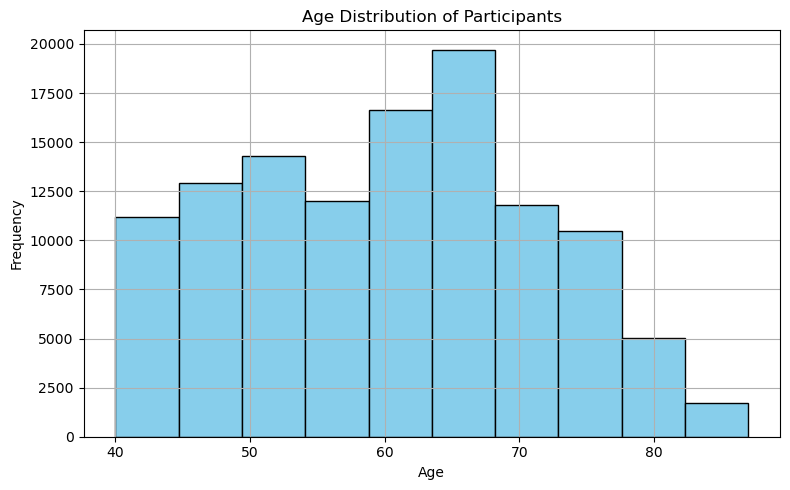

In [64]:
plt.figure(figsize=(8, 5))
plt.hist(df['age'], bins=10, edgecolor='black', color='skyblue')
plt.title('Age Distribution of Participants')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [65]:
df_grouped = df.groupby('age', as_index=False)['average_glucose_level_mg_dl'].mean()
df_grouped.head()

,age,average_glucose_level_mg_dl
0,40,156.209284
1,41,139.689112
2,42,132.681534
3,43,139.091321
4,44,133.140393


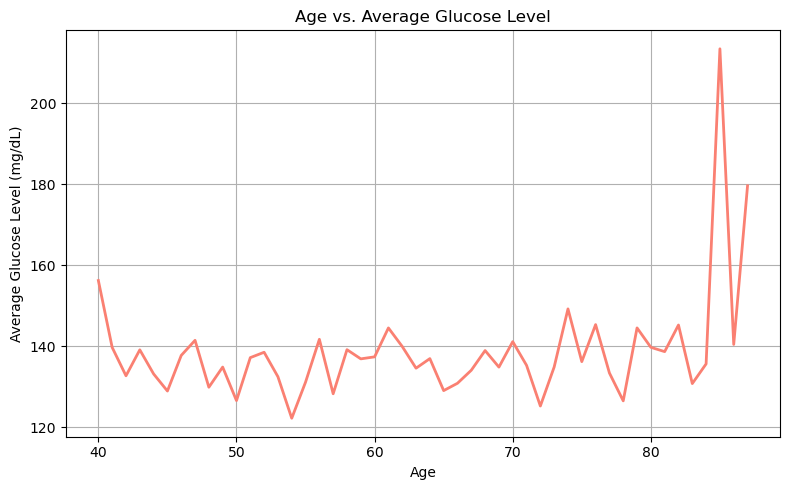

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(df_grouped['age'], df_grouped['average_glucose_level_mg_dl'], color='salmon', linewidth=2)
plt.title('Age vs. Average Glucose Level')
plt.xlabel('Age')
plt.ylabel('Average Glucose Level (mg/dL)')
plt.grid(True)
plt.tight_layout()
plt.show()


<div style="background: linear-gradient(to right, #FFD6A5, #FDFFB6); padding:20px; border-radius:10px; margin-top:20px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h2 style="color:#2B2D42; text-align:center;">📈 Feature Selection & Remove Anomalies </h2>
</div>

In [67]:
def display_data_distribution(dataset):
  num_cols = len(dataset.columns)
  num_rows = (num_cols + 1) // 2

  fig, axes = plt.subplots(num_rows, 2, figsize=(18, num_rows*3))
  axes = axes.flatten()
  palette = sns.color_palette("viridis", num_cols) #husl

  for i, (column, color) in enumerate(zip(dataset.columns, palette)):
    plot_data = dataset[column].dropna()
    temp_df = pd.DataFrame({column: plot_data})

    sns.violinplot(data=temp_df, orient='h', color=color, ax=axes[i], cut=0, width=0.8, linewidth=1)

    axes[i].set_title(f'Distribution of {column}', fontweight='bold', pad=10)
    axes[i].set_ylabel('')

    median = plot_data.median()
    axes[i].axvline(median, color='red', linestyle='--', linewidth=1.5)
    axes[i].text(median, 0.5, f'Median: {median:.2f}', ha='left', va='center', color='red',backgroundcolor='white', fontsize=10)

  for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

  plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=2.0)
  plt.show()

In [68]:
target_feature = ["type_ii_diabetes"]
selected_features = ["elevated_a1c_levels", "high_blood_pressure", "first_condition_start_date", "last_condition_end_date"]

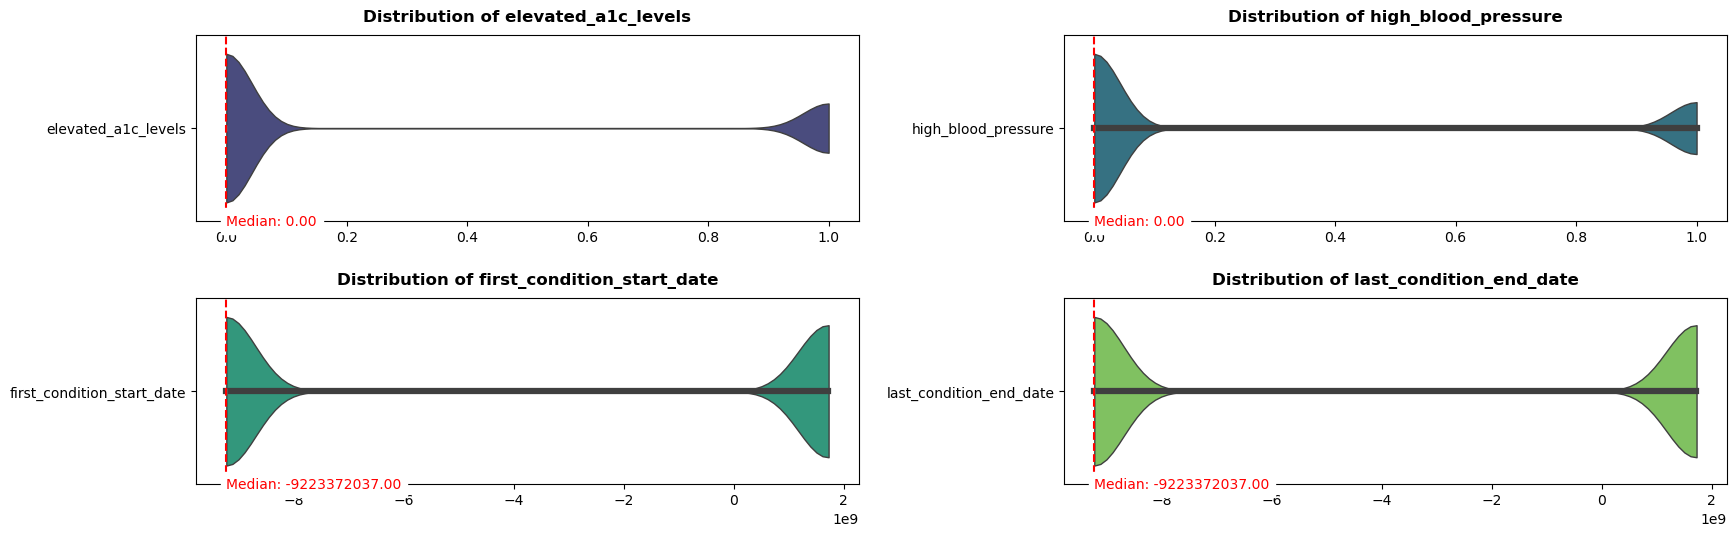

In [69]:
display_data_distribution(full_patient_data[selected_features])

In [70]:
X = full_patient_data[selected_features]
y = full_patient_data[target_feature]

feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [71]:
results = []
def evaluate_model(name, y_test, y_pred):
    return {
        'Model Performance' : name,
        'Model Mean Square Error (MSE)' : mean_squared_error(y_test, y_pred),
        'Model Root Mean Square Error (RMSE)' : np.sqrt(mean_squared_error(y_test, y_pred)),
        'Model Mean Absolute Error (MAE)' : mean_absolute_error(y_test, y_pred),
        'Model R-squared Score (R²)' : r2_score(y_test, y_pred),
    }

<div style="background: linear-gradient(to right, #FFD6A5, #FDFFB6); padding:20px; border-radius:10px; margin-top:20px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h2 style="color:#2B2D42; text-align:center;">🤖 AI Modeling </h2>
</div>

#### ANN

In [72]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.iloc[:, 0].values, dtype=torch.float32).view(-1, 1)

def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 64, 256, step=32)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    
    layers = []
    input_dim = X_train_tensor.shape[1]
    layers.append(nn.Linear(input_dim, hidden_size))
    layers.append(nn.ReLU())

    for i in range(num_layers - 1):
        layers.append(nn.Linear(hidden_size, hidden_size))
        layers.append(nn.ReLU())

    layers.append(nn.Linear(hidden_size, 1))  #Output
    model = nn.Sequential(*layers)

    #Loss & optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    return loss.item() 

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-08-12 18:10:35,482] A new study created in memory with name: no-name-9aa4e232-794a-47e5-8e8a-6db15a3f7d83
[I 2025-08-12 18:10:39,372] Trial 0 finished with value: 0.07667499780654907 and parameters: {'hidden_size': 64, 'lr': 0.0018916116604387207, 'num_layers': 2}. Best is trial 0 with value: 0.07667499780654907.
[I 2025-08-12 18:10:41,413] Trial 1 finished with value: 0.07655243575572968 and parameters: {'hidden_size': 96, 'lr': 0.008471099369665065, 'num_layers': 2}. Best is trial 1 with value: 0.07655243575572968.
[I 2025-08-12 18:10:42,000] Trial 2 finished with value: 0.07700911909341812 and parameters: {'hidden_size': 64, 'lr': 0.0010444013835198128, 'num_layers': 1}. Best is trial 1 with value: 0.07655243575572968.
[I 2025-08-12 18:10:47,352] Trial 3 finished with value: 0.07701946049928665 and parameters: {'hidden_size': 192, 'lr': 0.00013505973607883057, 'num_layers': 2}. Best is trial 1 with value: 0.07655243575572968.
[I 2025-08-12 18:10:48,760] Trial 4 finished with

Best Hyperparameters: {'hidden_size': 256, 'lr': 0.003428763133650004, 'num_layers': 3}


In [73]:
hidden_size = best_params['hidden_size']
lr = best_params['lr']
num_layers = best_params['num_layers']

layers = []
input_dim = X_train_tensor.shape[1]
layers.append(nn.Linear(input_dim, hidden_size))
layers.append(nn.ReLU())

for i in range(num_layers - 1):
    layers.append(nn.Linear(hidden_size, hidden_size))
    layers.append(nn.ReLU())

layers.append(nn.Linear(hidden_size, 1))  #Output
best_model = nn.Sequential(*layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=lr)

for epoch in range(50):
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
best_model.eval()
with torch.no_grad():
    y_pred_tensor = best_model(X_test_tensor)

y_pred = y_pred_tensor.numpy()

In [74]:
model_values = evaluate_model("ANN", y_test, y_pred)
results.append(model_values)
model_values

{'Model Performance': 'ANN',
 'Model Mean Square Error (MSE)': 0.0758364126086235,
 'Model Root Mean Square Error (RMSE)': np.float64(0.2753841182941084),
 'Model Mean Absolute Error (MAE)': 0.1508880853652954,
 'Model R-squared Score (R²)': 0.519251823425293}

#### CNN

In [75]:
if not isinstance(X_train, np.ndarray):
    X_train = X_train.to_numpy()
if not isinstance(X_test, np.ndarray):
    X_test = X_test.to_numpy()
if not isinstance(y_train, np.ndarray):
    y_train = y_train.to_numpy()
if not isinstance(y_test, np.ndarray):
    y_test = y_test.to_numpy()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # [N, 1, L]
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
y_test_tensor  = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

class CNNWrapper(nn.Module):
    def __init__(self, input_channels, input_length, num_filters, kernel_size, num_conv_layers):
        super(CNNWrapper, self).__init__()

        layers = []
        in_channels = input_channels
        L = input_length

        for i in range(num_conv_layers):
            k = min(kernel_size, L)
            layers.append(nn.Conv1d(in_channels, num_filters, kernel_size=k, padding="same"))
            layers.append(nn.ReLU())
            in_channels = num_filters

        self.conv_layers = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters * L, 1)

    def forward(self, x):
        out = self.conv_layers(x)
        out = torch.flatten(out, start_dim=1)
        out = self.fc(out)
        return out

def objective(trial):
    num_filters = trial.suggest_categorical("num_filters", [32, 48, 64, 96, 128])
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    num_conv_layers = trial.suggest_int("num_conv_layers", 1, 3)

    net = CNNWrapper(input_channels=1,
                     input_length=X_train_tensor.shape[2],
                     num_filters=num_filters,
                     kernel_size=kernel_size,
                     num_conv_layers=num_conv_layers)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    net.train()
    for epoch in range(20):
        optimizer.zero_grad()
        outputs = net(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
    net.eval()
    with torch.no_grad():
        y_pred = net(X_test_tensor).numpy()

    mse = mean_squared_error(y_test, y_pred)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-08-12 18:13:06,832] A new study created in memory with name: no-name-b529c643-3e70-4c72-ac53-a665d0a725fe
[I 2025-08-12 18:13:09,266] Trial 0 finished with value: 0.08584971725940704 and parameters: {'num_filters': 128, 'kernel_size': 4, 'lr': 0.004977260529388972, 'num_conv_layers': 1}. Best is trial 0 with value: 0.08584971725940704.
[I 2025-08-12 18:13:11,645] Trial 1 finished with value: 0.09606688469648361 and parameters: {'num_filters': 128, 'kernel_size': 3, 'lr': 0.00017503049535808234, 'num_conv_layers': 1}. Best is trial 0 with value: 0.08584971725940704.
[I 2025-08-12 18:13:13,337] Trial 2 finished with value: 0.13913993537425995 and parameters: {'num_filters': 32, 'kernel_size': 3, 'lr': 0.0001357123333220159, 'num_conv_layers': 2}. Best is trial 0 with value: 0.08584971725940704.
[I 2025-08-12 18:13:30,519] Trial 3 finished with value: 0.07807417958974838 and parameters: {'num_filters': 128, 'kernel_size': 4, 'lr': 0.002130331683818058, 'num_conv_layers': 2}. Best 

Best Hyperparameters: {'num_filters': 32, 'kernel_size': 4, 'lr': 0.003378400227905957, 'num_conv_layers': 2}


In [76]:
# Extract best hyperparameters from Optuna
num_filters = best_params['num_filters']
kernel_size = best_params['kernel_size']
lr = best_params['lr']
num_conv_layers = best_params['num_conv_layers']

# Define CNN Model
class BestCNN(nn.Module):
    def __init__(self, input_channels, input_length, num_filters, kernel_size, num_conv_layers):
        super(BestCNN, self).__init__()
        layers = []
        in_channels = input_channels
        L = input_length

        for i in range(num_conv_layers):
            k = min(kernel_size, L)  # Ensure kernel size not bigger than input
            layers.append(nn.Conv1d(in_channels, num_filters, kernel_size=k, padding="same"))
            layers.append(nn.ReLU())
            in_channels = num_filters

        self.conv_layers = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters * L, 1)

    def forward(self, x):
        out = self.conv_layers(x)
        out = torch.flatten(out, start_dim=1)
        out = self.fc(out)
        return out

# Initialize model with best parameters
best_model = BestCNN(input_channels=1,
                     input_length=X_train_tensor.shape[2],
                     num_filters=num_filters,
                     kernel_size=kernel_size,
                     num_conv_layers=num_conv_layers)

criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=lr)

# Training loop
for epoch in range(50):
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation
best_model.eval()
with torch.no_grad():
    y_pred_tensor = best_model(X_test_tensor)

y_pred = y_pred_tensor.numpy()


In [77]:
model_values = evaluate_model("CNN", y_test, y_pred)
results.append(model_values)
model_values

{'Model Performance': 'CNN',
 'Model Mean Square Error (MSE)': 0.0758562907576561,
 'Model Root Mean Square Error (RMSE)': np.float64(0.27542020760586194),
 'Model Mean Absolute Error (MAE)': 0.1498814821243286,
 'Model R-squared Score (R²)': 0.5191258192062378}

#### RNN

In [78]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # [N, seq_len=1, features]
# If y_train is already a NumPy array
if isinstance(y_train, np.ndarray):
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
else:  # If it's still a Pandas Series/DataFrame
    y_train_tensor = torch.tensor(y_train.iloc[:, 0].values, dtype=torch.float32).reshape(-1, 1)
    
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 64, 256, step=32)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 3)

    input_dim = X_train_tensor.shape[2]  # features
    output_dim = 1

    # RNN model
    class RNNModel(nn.Module):
        def __init__(self, input_dim, hidden_size, num_layers, output_dim):
            super(RNNModel, self).__init__()
            self.rnn = nn.RNN(input_dim, hidden_size, num_layers, batch_first=True)
            self.fc = nn.Linear(hidden_size, output_dim)

        def forward(self, x):
            out, _ = self.rnn(x)                 # out: [batch, seq_len, hidden]
            out = out[:, -1, :]                  # take last timestep
            out = self.fc(out)                   # map to output
            return out

    model = RNNModel(input_dim, hidden_size, num_layers, output_dim)

    # Loss & optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(50):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    return loss.item()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

best_params = study.best_params
print("Best Hyperparameters:", best_params)



[I 2025-08-12 18:14:53,212] A new study created in memory with name: no-name-0a4d4673-ae59-4b7e-aa40-9e9573efa5a1
[I 2025-08-12 18:15:11,752] Trial 0 finished with value: 0.07724319398403168 and parameters: {'hidden_size': 224, 'lr': 0.00027121281797865855, 'num_layers': 2}. Best is trial 0 with value: 0.07724319398403168.
[I 2025-08-12 18:15:14,560] Trial 1 finished with value: 0.07695411145687103 and parameters: {'hidden_size': 96, 'lr': 0.004501482186689958, 'num_layers': 1}. Best is trial 1 with value: 0.07695411145687103.
[I 2025-08-12 18:15:20,904] Trial 2 finished with value: 0.07919947057962418 and parameters: {'hidden_size': 192, 'lr': 0.00039850284051534186, 'num_layers': 1}. Best is trial 1 with value: 0.07695411145687103.
[I 2025-08-12 18:15:29,254] Trial 3 finished with value: 0.0770493894815445 and parameters: {'hidden_size': 224, 'lr': 0.005499249301903164, 'num_layers': 1}. Best is trial 1 with value: 0.07695411145687103.
[I 2025-08-12 18:15:35,647] Trial 4 finished wit

Best Hyperparameters: {'hidden_size': 96, 'lr': 0.004501482186689958, 'num_layers': 1}


In [79]:
hidden_size = best_params['hidden_size']
lr = best_params['lr']
num_layers = best_params['num_layers']

# Define RNN model
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, output_dim=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)         # out: [batch, seq_len, hidden]
        out = out[:, -1, :]          # take last timestep
        out = self.fc(out)           # fully connected -> output
        return out

# Input dims
input_dim = X_train_tensor.shape[2]   # [N, seq_len, features]
output_dim = 1

best_model = RNNModel(input_dim, hidden_size, num_layers, output_dim)

# Loss & optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(best_model.parameters(), lr=lr)

# Training loop
for epoch in range(50):
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Convert test set for RNN: [N, seq_len=1, features]
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

best_model.eval()
with torch.no_grad():
    y_pred_tensor = best_model(X_test_tensor)

y_pred = y_pred_tensor.numpy()


In [80]:
model_values = evaluate_model("RNN", y_test, y_pred)
results.append(model_values)
model_values

{'Model Performance': 'RNN',
 'Model Mean Square Error (MSE)': 0.0765579491853714,
 'Model Root Mean Square Error (RMSE)': np.float64(0.27669107174856833),
 'Model Mean Absolute Error (MAE)': 0.16495221853256226,
 'Model R-squared Score (R²)': 0.5146777629852295}

#### Random Forest

In [81]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=50)
    max_depth = trial.suggest_int('max_depth', 4, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # ✅ Use y_train.ravel() (works whether array or DataFrame column)
    model.fit(X_train, y_train.ravel())
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred)


# Run Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective_rf, n_trials=20)

best_params = study.best_params
print("Best Random Forest Hyperparameters:", best_params)


[I 2025-08-12 18:17:56,198] A new study created in memory with name: no-name-e6483ac5-e444-419e-b2c9-2f6e3b3968e3
[I 2025-08-12 18:17:56,427] Trial 0 finished with value: 0.04917926668724112 and parameters: {'n_estimators': 50, 'max_depth': 10, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.04917926668724112.
[I 2025-08-12 18:17:57,108] Trial 1 finished with value: 0.06094356395394076 and parameters: {'n_estimators': 200, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.04917926668724112.
[I 2025-08-12 18:17:57,546] Trial 2 finished with value: 0.03755227787109679 and parameters: {'n_estimators': 100, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.03755227787109679.
[I 2025-08-12 18:17:58,128] Trial 3 finished with value: 0.046502122006872544 and parameters: {'n_estimators': 150, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 2 wit

Best Random Forest Hyperparameters: {'n_estimators': 50, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 3}


In [82]:
best_rf_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train, y_train.ravel())
y_pred = best_rf_model.predict(X_test)

In [83]:
model_values = evaluate_model("Random Forest", y_test, y_pred)
results.append(model_values)
model_values

{'Model Performance': 'Random Forest',
 'Model Mean Square Error (MSE)': 0.035853740692947236,
 'Model Root Mean Square Error (RMSE)': np.float64(0.18935084022244855),
 'Model Mean Absolute Error (MAE)': 0.07258552069150227,
 'Model R-squared Score (R²)': 0.7727131135596157}

#### XGBoost 

In [84]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def objective_xgb(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 0.3, log=True)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    gamma = trial.suggest_float("gamma", 0, 5)
    reg_alpha = trial.suggest_float("reg_alpha", 0, 5)
    reg_lambda = trial.suggest_float("reg_lambda", 0, 5)

    # Define trial model
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        n_jobs=-1
    )

    # Fix y_train type issue
    y_train_fit = y_train.ravel() if isinstance(y_train, np.ndarray) else y_train.values.ravel()

    # Train & predict
    model.fit(X_train, y_train_fit)
    y_pred = model.predict(X_test)

    # Return metric Optuna will minimize
    return mean_squared_error(y_test, y_pred)

# Run Optuna optimization
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=20)

# Best parameters after search
best_params_xgb = study_xgb.best_params
print("Best XGB Hyperparameters:", best_params_xgb)

[I 2025-08-12 18:18:06,745] A new study created in memory with name: no-name-3894464c-34ae-4e7d-b05a-d80d82228ad8
[I 2025-08-12 18:18:07,778] Trial 0 finished with value: 0.10619679093360901 and parameters: {'n_estimators': 400, 'max_depth': 11, 'learning_rate': 0.0010364625132255074, 'subsample': 0.9515617581420974, 'colsample_bytree': 0.8312517765205529, 'gamma': 4.671574280689043, 'reg_alpha': 2.5347540805973736, 'reg_lambda': 0.6843338750288669}. Best is trial 0 with value: 0.10619679093360901.
[I 2025-08-12 18:18:08,336] Trial 1 finished with value: 0.03861887380480766 and parameters: {'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.12829606357976403, 'subsample': 0.7928666040863203, 'colsample_bytree': 0.9075299467412979, 'gamma': 0.048960575492246194, 'reg_alpha': 3.888874663069746, 'reg_lambda': 0.1477414931267601}. Best is trial 1 with value: 0.03861887380480766.
[I 2025-08-12 18:18:08,455] Trial 2 finished with value: 0.13541051745414734 and parameters: {'n_estimators

Best XGB Hyperparameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.1018964500217343, 'subsample': 0.5601528662643313, 'colsample_bytree': 0.947469243055001, 'gamma': 0.010893684218495459, 'reg_alpha': 1.099880336620068, 'reg_lambda': 1.8114431694242397}


In [85]:
# Train final model using best params
best_xgb_model = XGBRegressor(**best_params_xgb, random_state=42, n_jobs=-1)
y_train_fit = y_train.ravel() if isinstance(y_train, np.ndarray) else y_train.values.ravel()
best_xgb_model.fit(X_train, y_train_fit)

# Final prediction
y_pred = best_xgb_model.predict(X_test)

In [86]:
model_values = evaluate_model("XGBoost", y_test, y_pred)
results.append(model_values)
model_values

{'Model Performance': 'XGBoost',
 'Model Mean Square Error (MSE)': 0.03601487725973129,
 'Model Root Mean Square Error (RMSE)': np.float64(0.18977586058224394),
 'Model Mean Absolute Error (MAE)': 0.07627828419208527,
 'Model R-squared Score (R²)': 0.771691620349884}

#### Logistic Regression

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def objective_logreg(trial):
    C = trial.suggest_float("C", 1e-3, 10, log=True)
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs", "saga"])
    
    model = LogisticRegression(C=C, solver=solver, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return 1 - accuracy_score(y_test, y_pred)  # minimize error

study_logreg = optuna.create_study(direction="minimize")
study_logreg.optimize(objective_logreg, n_trials=20)
best_params_logreg = study_logreg.best_params
print("Best Logistic Regression Hyperparameters:", best_params_logreg)

[I 2025-08-12 18:18:17,118] A new study created in memory with name: no-name-12c5e6cd-942a-453f-ac35-c9e0bc681511
[I 2025-08-12 18:18:17,314] Trial 0 finished with value: 0.11125190795726181 and parameters: {'C': 0.010176153451896633, 'solver': 'saga'}. Best is trial 0 with value: 0.11125190795726181.
[I 2025-08-12 18:18:17,392] Trial 1 finished with value: 0.11125190795726181 and parameters: {'C': 0.01316775392145834, 'solver': 'liblinear'}. Best is trial 0 with value: 0.11125190795726181.
[I 2025-08-12 18:18:17,441] Trial 2 finished with value: 0.11125190795726181 and parameters: {'C': 0.04304280659759486, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.11125190795726181.
[I 2025-08-12 18:18:17,644] Trial 3 finished with value: 0.11125190795726181 and parameters: {'C': 0.6321785664706, 'solver': 'saga'}. Best is trial 0 with value: 0.11125190795726181.
[I 2025-08-12 18:18:17,717] Trial 4 finished with value: 0.11125190795726181 and parameters: {'C': 0.009277039726035368, 'solver': 

Best Logistic Regression Hyperparameters: {'C': 0.010176153451896633, 'solver': 'saga'}


In [88]:
# Train best model
best_logreg = LogisticRegression(**best_params_logreg, max_iter=1000, random_state=42)
best_logreg.fit(X_train, y_train)
y_pred = best_logreg.predict(X_test)

In [89]:
model_values = evaluate_model("Logistic Regression", y_test, y_pred)
results.append(model_values)
model_values

{'Model Performance': 'Logistic Regression',
 'Model Mean Square Error (MSE)': 0.11125190795726175,
 'Model Root Mean Square Error (RMSE)': np.float64(0.3335444617397533),
 'Model Mean Absolute Error (MAE)': 0.11125190795726175,
 'Model R-squared Score (R²)': 0.2947430510331034}

#### Gradient Boosting Regressor (GBR)

In [90]:
from sklearn.ensemble import GradientBoostingRegressor

def objective_gbr(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500, step=50)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    y_train_fit = y_train.ravel() if isinstance(y_train, np.ndarray) else y_train.values.ravel()
    model.fit(X_train, y_train_fit)
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred)

# Run Optuna
study_gbr = optuna.create_study(direction="minimize")
study_gbr.optimize(objective_gbr, n_trials=20)
best_params_gbr = study_gbr.best_params
print("Best Gradient Boosting Hyperparameters:", best_params_gbr)

[I 2025-08-12 18:18:19,749] A new study created in memory with name: no-name-c6992b93-b33d-40db-b1af-f390c3efa77e
[I 2025-08-12 18:18:32,808] Trial 0 finished with value: 0.035719803632885766 and parameters: {'n_estimators': 500, 'learning_rate': 0.15459949196948444, 'max_depth': 7, 'subsample': 0.9527912238290637, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.035719803632885766.
[I 2025-08-12 18:18:41,519] Trial 1 finished with value: 0.037774903241000544 and parameters: {'n_estimators': 500, 'learning_rate': 0.13096968200750173, 'max_depth': 4, 'subsample': 0.7853735971734788, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.035719803632885766.
[I 2025-08-12 18:18:53,928] Trial 2 finished with value: 0.03574114715163784 and parameters: {'n_estimators': 450, 'learning_rate': 0.12287382893984314, 'max_depth': 14, 'subsample': 0.8179779412886983, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.035

Best Gradient Boosting Hyperparameters: {'n_estimators': 300, 'learning_rate': 0.14213255298498312, 'max_depth': 11, 'subsample': 0.768661049088619, 'min_samples_split': 3, 'min_samples_leaf': 5}


In [91]:
# Train final model
best_gbr = GradientBoostingRegressor(**best_params_gbr, random_state=42)
best_gbr.fit(X_train, y_train_fit)
y_pred = best_gbr.predict(X_test)

In [92]:
model_values = evaluate_model("Gradient Boosting", y_test, y_pred)
results.append(model_values)
model_values

{'Model Performance': 'Gradient Boosting',
 'Model Mean Square Error (MSE)': 0.035692551670629055,
 'Model Root Mean Square Error (RMSE)': np.float64(0.18892472487906142),
 'Model Mean Absolute Error (MAE)': 0.07112039494869123,
 'Model R-squared Score (R²)': 0.7737349358382121}

<div style="background: linear-gradient(to right, #FFD6A5, #FDFFB6); padding:20px; border-radius:10px; margin-top:20px; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h2 style="color:#2B2D42; text-align:center;"> Results </h2>
</div>

In [93]:
results_df = pd.DataFrame(results)
results_df

,Model Performance,Model Mean Square Error (MSE),Model Root Mean Square Error (RMSE),Model Mean Absolute Error (MAE),Model R-squared Score (R²)
0,ANN,0.075836,0.275384,0.150888,0.519252
1,CNN,0.075856,0.275420,0.149881,0.519126
2,RNN,0.076558,0.276691,0.164952,0.514678
3,Random Forest,0.035854,0.189351,0.072586,0.772713
4,XGBoost,0.036015,0.189776,0.076278,0.771692
5,Logistic Regression,0.111252,0.333544,0.111252,0.294743
6,Gradient Boosting,0.035693,0.188925,0.071120,0.773735


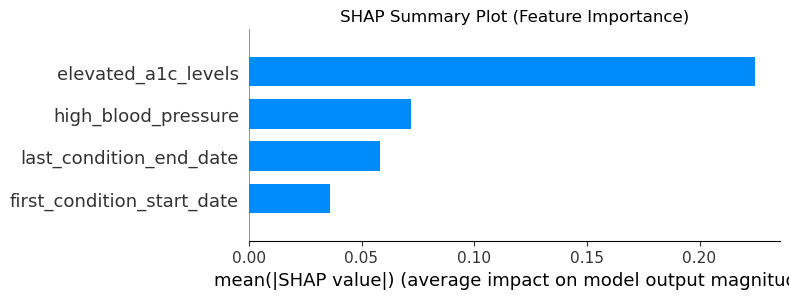

In [94]:
import shap

X_test = pd.DataFrame(X_test, columns=feature_names)

explainer = shap.TreeExplainer(best_gbr)
shap_values = explainer.shap_values(X_test)
shap.initjs()

plt.title("SHAP Summary Plot (Feature Importance)")
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

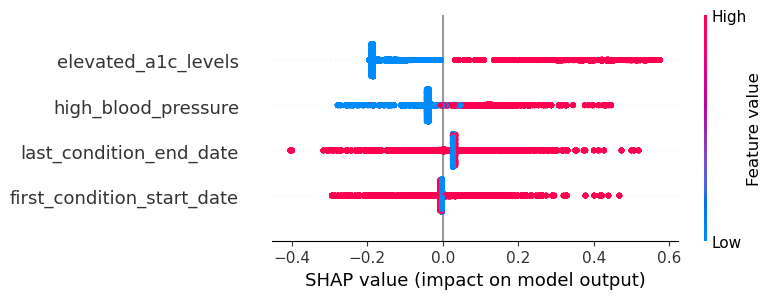

In [95]:
shap.summary_plot(shap_values, X_test)

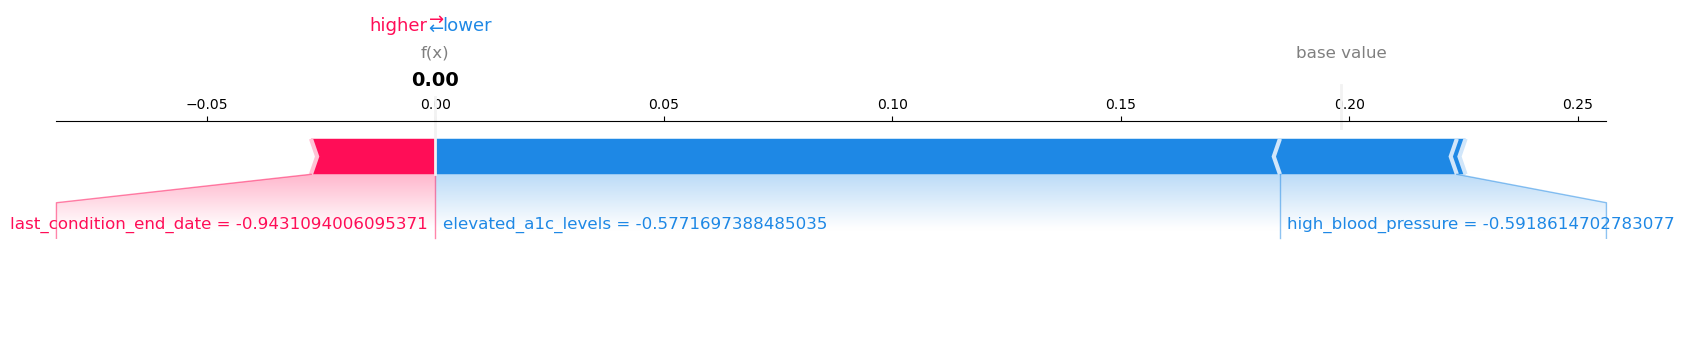

In [96]:
X_test = pd.DataFrame(X_test, columns=feature_names)
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :], matplotlib=True)